# Part 1: CellPose Segmentation

In [ ]:
!pip install torch torchvision torchaudio
!pip install omnipose
!pip install "opencv-python-headless<4.3"

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install "cellpose==2.3.2"

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import numpy as np
import time, sys, random, shutil
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import models, core
from cellpose.io import logger_setup

# Configure Matplotlib
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

# Enable logging for Cellpose
logger_setup()

# Download available models from Cellpose
model_list = models.MODEL_NAMES

creating new log file
2024-11-05 20:51:20,267 [INFO] WRITING LOG OUTPUT TO /home/ubuntu/.cellpose/run.log
2024-11-05 20:51:20,268 [INFO] 
cellpose version: 	2.3.2 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.1.2+cu121


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import zipfile
import os
zip_file_path = 'downsampled_data.zip'
extract_dir = '.'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

## Load Image Files

In [ ]:
from skimage.io import imread

# Set input directory and image format
input_dir = os.path.join("downsampled_data", "")
image_format = "tiff"

# Gather files from input directory
filessss = [os.path.join(r, f) for r, _, fs in os.walk(input_dir)
         for f in fs if f.endswith(image_format)]
print(f"Number of images loaded: {len(filessss)}")
if not filessss:
    print("Cannot read image files. Check if folder has images.")

Number of images loaded: 2867


## Load and Preprocess Images

In [ ]:
imgs = [imread(f) for f in filessss]

# Adjust channel position if necessary
for i, im in enumerate(imgs):
    if len(im.shape) == 3 and im.shape.index(min(im.shape)) == 0:
        imgs[i] = im.transpose(1, 2, 0)

nimg = len(imgs)
print(f"Number of images loaded: {nimg}")

Number of images loaded: 2867


## Model Choice Widget

In [ ]:
import ipywidgets as widgets
from IPython.display import display

model_choices = widgets.Dropdown(
    options=model_list,
    value='cyto2',
    description='Model Choice:',
    disabled=False,
)

## Model Configuration

In [ ]:
from cellpose import models

# Retrieve user model choice
model_type = model_choices.value
Use_nuclear_channel = True

# Define channels for segmentation
segment_channel = 1
nuclear_channel = 3 if Use_nuclear_channel else 0
channels = [segment_channel, nuclear_channel] if model_type != "nuclei" else [segment_channel, 0]

# Initialize Cellpose model
model = models.CellposeModel(gpu=True, model_type=model_type)

diameter = None  # Estimate cell size per image if not set
print("Diameter is set to None. Cell size will be estimated.")

2024-11-05 21:25:01,013 [INFO] >> cyto2 << model set to be used
2024-11-05 21:25:01,016 [INFO] Downloading: "https://www.cellpose.org/models/cyto2torch_0" to /home/ubuntu/.cellpose/models/cyto2torch_0



100%|████████████████████████████████████████████████████████| 25.3M/25.3M [00:02<00:00, 10.8MB/s]


2024-11-05 21:25:04,889 [INFO] ** TORCH CUDA version installed and working. **
2024-11-05 21:25:04,891 [INFO] >>>> using GPU
2024-11-05 21:25:05,183 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
Diameter is set to None. Cell size will be estimated.


In [ ]:
! pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable


Processing Image 1 of 2867


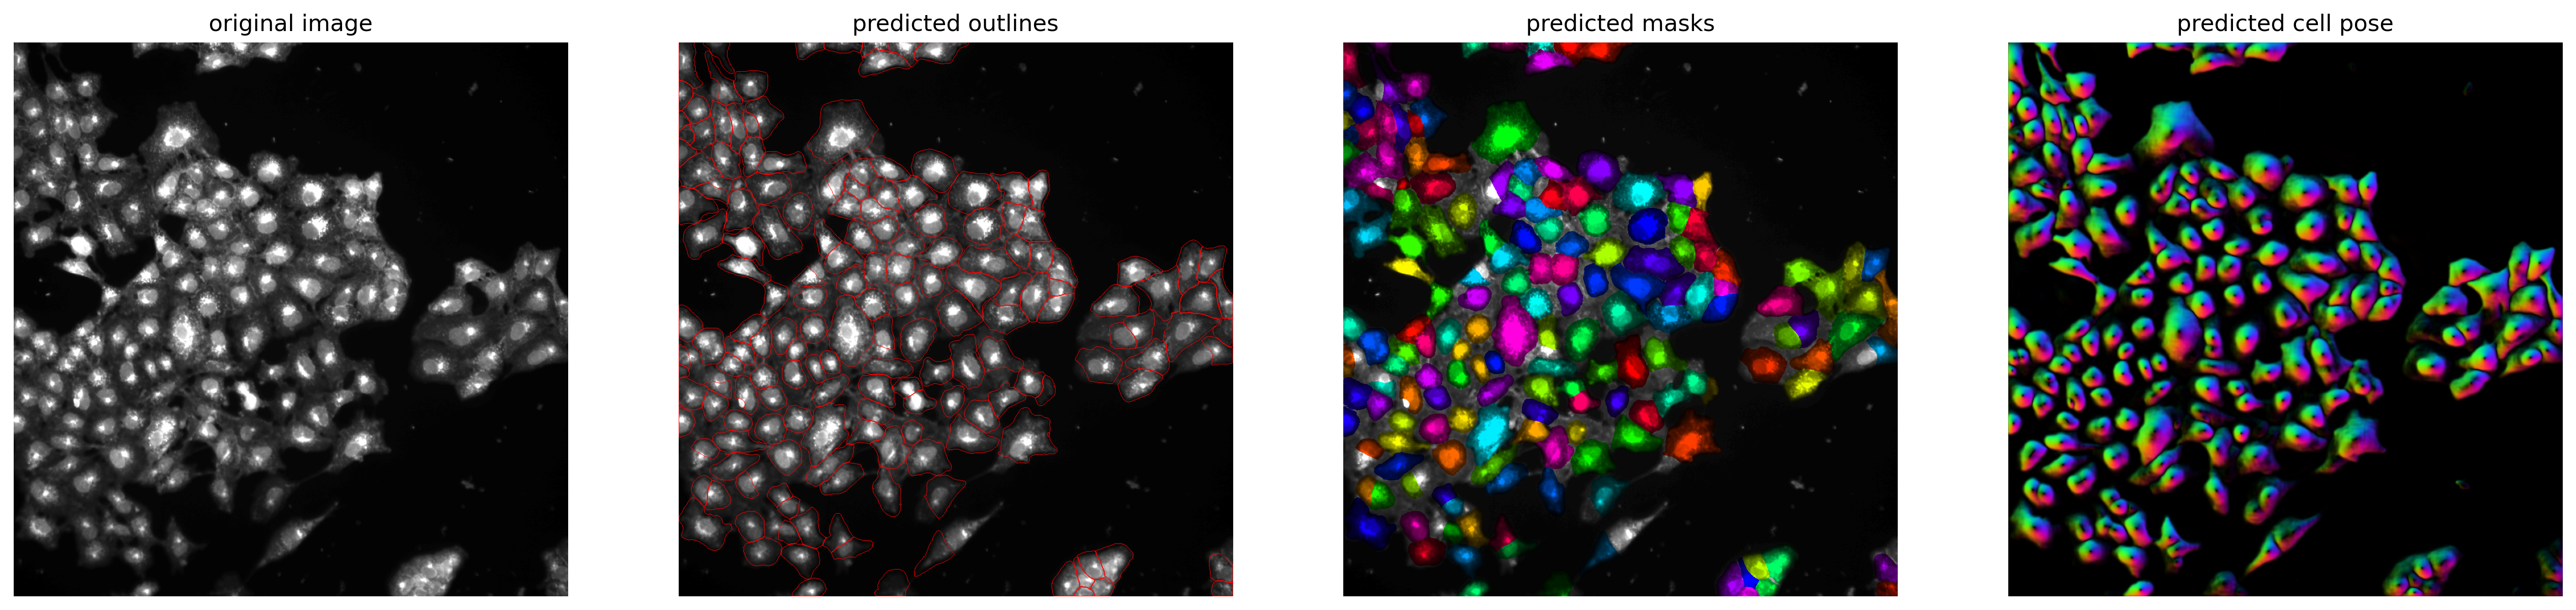

Processing Image 2 of 2867
Processing Image 3 of 2867
Processing Image 4 of 2867
Processing Image 5 of 2867
Processing Image 6 of 2867
Processing Image 7 of 2867
Processing Image 8 of 2867
Processing Image 9 of 2867
Processing Image 10 of 2867
Processing Image 11 of 2867
Processing Image 12 of 2867
Processing Image 13 of 2867
Processing Image 14 of 2867
Processing Image 15 of 2867
Processing Image 16 of 2867
Processing Image 17 of 2867
Processing Image 18 of 2867
Processing Image 19 of 2867
Processing Image 20 of 2867
Processing Image 21 of 2867
Processing Image 22 of 2867
Processing Image 23 of 2867
Processing Image 24 of 2867
Processing Image 25 of 2867
Processing Image 26 of 2867
Processing Image 27 of 2867
Processing Image 28 of 2867
Processing Image 29 of 2867
Processing Image 30 of 2867
Processing Image 31 of 2867
Processing Image 32 of 2867
Processing Image 33 of 2867
Processing Image 34 of 2867
Processing Image 35 of 2867
Processing Image 36 of 2867
Processing Image 37 of 2867


In [ ]:
from skimage.measure import regionprops, label
from skimage.util import img_as_ubyte
from cellpose import plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

base_dir = "cellpose_results"
os.makedirs(f"{base_dir}/masks", exist_ok=True)
os.makedirs(f"{base_dir}/flows", exist_ok=True)

flow_threshold = 0.7
cellprob_threshold = -5

# Function to check if mask and flow files exist
def is_processed(filename):
    mask_path = f"{base_dir}/masks/masks_{filename}.tiff"
    flow_path = f"{base_dir}/flows/flows_{filename}.tiff"
    return os.path.isfile(mask_path) and os.path.isfile(flow_path)

# Iterate through all images for segmentation
for i, img in enumerate(imgs):
    filename = os.path.basename(filessss[i]).split('.')[0].split('_')[0]

    # Check if the image has already been processed
    if is_processed(filename):
        print(f"Skipping Image {i + 1} of {len(imgs)} (Already processed: {filename})")
        continue

    print(f"Processing Image {i + 1} of {len(imgs)}")

    img = img_as_ubyte(img) if img.dtype != np.uint8 else img

    masks, flows, _ = model.eval(
        img, diameter=diameter,
        flow_threshold=flow_threshold,
        cellprob_threshold=cellprob_threshold,
        channels=channels
    )

    plt.imsave(f"{base_dir}/masks/masks_{filename}.tiff", masks, cmap='gray')
    plt.imsave(f"{base_dir}/flows/flows_{filename}.tiff", flows[0], cmap='gray')

    labeled_mask = label(masks)
    properties = regionprops(labeled_mask, intensity_image=img)

    image_features = []
    for prop in properties:
        image_features.append({
            "CoreFileName": filename,
            "label": prop.label,
            "bbox": prop.bbox,
            "area": prop.area,
            "convex_area": prop.convex_area,
            "perimeter": prop.perimeter,
            "eccentricity": prop.eccentricity,
            "mean_intensity": prop.mean_intensity,
            "min_intensity": prop.min_intensity,
            "max_intensity": prop.max_intensity,
            "major_axis_length": prop.major_axis_length,
            "minor_axis_length": prop.minor_axis_length,
            "orientation": prop.orientation,
            "solidity": prop.solidity,
            "extent": prop.extent,
            "centroid": prop.centroid,
        })

    df_image_features = pd.DataFrame(image_features)
    csv_path = f"{base_dir}/extracted_features.csv"

    if not os.path.isfile(csv_path):
        df_image_features.to_csv(csv_path, index=False, mode='w')
    else:
        df_image_features.to_csv(csv_path, index=False, mode='a', header=False)

    if i == 0:
        fig = plt.figure(figsize=(24, 8))
        plot.show_segmentation(fig, img, masks, flows[0], channels=channels)
        plt.show()

print("Segmentation completed. Features, masks, and flows saved to Google Drive.")

# Part 2: Extracted Features and Metadata Cleaning

## Extracted Features cleaning

In [ ]:
import pandas as pd
df_all_features = pd.read_csv("cellpose_results/extracted_features.csv")

In [ ]:
print("Extracted Features from All Images:")
display(df_all_features)

Extracted Features from All Images:


CoreFileName  label                      bbox    area  convex_area  \
0         r06c15f08      1            (0, 0, 91, 48)  2864.0       3359.0   
1         r06c15f08      2          (0, 47, 62, 109)  1724.0       2152.0   
2         r06c15f08      3         (0, 227, 35, 284)  1421.0       1524.0   
3         r06c15f08      4         (0, 283, 22, 358)  1436.0       1502.0   
4         r06c15f08      5         (0, 354, 29, 412)  1003.0       1354.0   
...             ...    ...                       ...     ...          ...   
491421    r07c06f06    149   (957, 1052, 1006, 1080)  1202.0       1238.0   
491422    r07c06f06    150   (1007, 974, 1080, 1051)  4606.0       4977.0   
491423    r07c06f06    151    (1034, 527, 1080, 606)  2510.0       2655.0   
491424    r07c06f06    152  (1049, 1044, 1080, 1080)   905.0        962.0   
491425    r07c06f06    153     (1057, 67, 1080, 133)  1211.0       1240.0   

         perimeter  eccentricity  mean_intensity  min_intensity  \
0       269.338095      0.918268       18.379888            2.0   
1       221.752309      0.886999        7.506961            2.0   
2       164.461941      0.841511       19.117523            3.0   
3       183.112698      0.959293       13.015320            3.0   
4       167.254834      0.920883       27.358923            4.0   
...            ...           ...             ...            ...   
491421  140.284271      0.804541        7.845258            3.0   
491422  296.030483      0.469620       16.245115            3.0   
491423  215.509668      0.767124       23.393625            3.0   
491424  122.870058      0.686911        7.074033            3.0   
491425  156.669048      0.931382        9.364162            3.0   

        max_intensity  major_axis_length  minor_axis_length  orientation  \
0                82.0         101.317362          40.117566     0.166557   
1                26.0          79.598741          36.756406     0.608052   
2                75.0          61.047597          32.980314    -1.320735   
3                68.0          81.974042          23.150600     1.554709   
4                89.0          65.119463          25.386115    -1.412091   
...               ...                ...                ...          ...   
491421           18.0          51.631494          30.663760    -0.053301   
491422           70.0          83.461075          73.685189    -0.656385   
491423           93.0          72.724483          46.652706     1.567504   
491424           12.0          41.082021          29.855996    -1.365254   
491425           39.0          66.715375          24.287296    -1.546518   

        solidity    extent                                  centroid  
0       0.852635  0.655678    (43.72870111731844, 18.06983240223464)  
1       0.801115  0.448491   (22.574825986078885, 81.63805104408353)  
2       0.932415  0.712281  (13.223786066150598, 251.57213230119635)  
3       0.956059  0.870303   (9.270194986072424, 320.78621169916437)  
4       0.740768  0.596314   (10.138584247258226, 379.4905284147557)  
...          ...       ...                                       ...  
491421  0.970921  0.876093    (981.7504159733777, 1066.435108153078)  
491422  0.925457  0.819427  (1044.7377333912289, 1011.9926183239253)  
491423  0.945386  0.690699   (1060.1059760956175, 570.5123505976096)  
491424  0.940748  0.810932  (1066.2530386740332, 1062.9337016574586)  
491425  0.976613  0.797760  (1069.6168455821635, 100.07927332782825)  

[491426 rows x 16 columns]

In [ ]:
df_all_features[['centroid_x', 'centroid_y']] = pd.DataFrame(
    df_all_features['centroid'].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist(),
    index=df_all_features.index
)

# Drop the original 'centroid' column
df_all_features = df_all_features.drop(columns=['centroid'])

In [ ]:
df_all_features.head()

CoreFileName  label               bbox    area  convex_area   perimeter  \
0    r06c15f08      1     (0, 0, 91, 48)  2864.0       3359.0  269.338095   
1    r06c15f08      2   (0, 47, 62, 109)  1724.0       2152.0  221.752309   
2    r06c15f08      3  (0, 227, 35, 284)  1421.0       1524.0  164.461941   
3    r06c15f08      4  (0, 283, 22, 358)  1436.0       1502.0  183.112698   
4    r06c15f08      5  (0, 354, 29, 412)  1003.0       1354.0  167.254834   

   eccentricity  mean_intensity  min_intensity  max_intensity  \
0      0.918268       18.379888            2.0           82.0   
1      0.886999        7.506961            2.0           26.0   
2      0.841511       19.117523            3.0           75.0   
3      0.959293       13.015320            3.0           68.0   
4      0.920883       27.358923            4.0           89.0   

   major_axis_length  minor_axis_length  orientation  solidity    extent  \
0         101.317362          40.117566     0.166557  0.852635  0.655678   
1          79.598741          36.756406     0.608052  0.801115  0.448491   
2          61.047597          32.980314    -1.320735  0.932415  0.712281   
3          81.974042          23.150600     1.554709  0.956059  0.870303   
4          65.119463          25.386115    -1.412091  0.740768  0.596314   

   centroid_x  centroid_y  
0   43.728701   18.069832  
1   22.574826   81.638051  
2   13.223786  251.572132  
3    9.270195  320.786212  
4   10.138584  379.490528

In [ ]:
rows_with_perimeter_zero = df_all_features[df_all_features['perimeter'] == 0.0]
print(rows_with_perimeter_zero)

       CoreFileName  label                    bbox  area  convex_area  \
74        r06c15f08     75    (457, 721, 458, 722)   1.0          1.0   
104       r06c15f08    105    (584, 421, 585, 422)   1.0          1.0   
130       r06c15f08    131    (696, 420, 697, 421)   1.0          1.0   
210       r02c22f03     36      (62, 773, 63, 774)   1.0          1.0   
211       r02c22f03     37      (63, 774, 65, 776)   2.0          2.0   
...             ...    ...                     ...   ...          ...   
491387    r07c06f06    115  (745, 1031, 746, 1033)   2.0          2.0   
491388    r07c06f06    116  (745, 1033, 746, 1034)   1.0          1.0   
491391    r07c06f06    119  (745, 1048, 746, 1049)   1.0          1.0   
491392    r07c06f06    120  (745, 1049, 746, 1051)   2.0          2.0   
491405    r07c06f06    133    (808, 905, 809, 906)   1.0          1.0   

        perimeter  eccentricity  mean_intensity  min_intensity  max_intensity  \
74            0.0           0.0           

didn't provide useful information, they are noise in the data, drop those

In [ ]:
# Drop rows where 'perimeter' is 0.0 and update the DataFrame
df_all_features = df_all_features[df_all_features['perimeter'] != 0.0]

## Metadata Cleaning

In [ ]:
import pandas as pd
metadata_path = 'cleaned_metadata.csv'
metadata = pd.read_csv(metadata_path,index_col=0)
metadata.head()

FileName_OrigRNA  Metadata_ChannelID Metadata_Plate  \
0  r01c01f01p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
1  r01c01f02p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
2  r01c01f03p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
3  r01c01f04p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
4  r01c01f05p01-ch3sk1fk1fl1.tiff                   5     BR00116991   

  Metadata_Well  Metadata_Site  Metadata_AbsPositionZ  Metadata_PositionX  \
0           A01              1               0.134679           -0.000323   
1           A01              2               0.134679           -0.000969   
2           A01              3               0.134673            0.000323   
3           A01              4               0.134674            0.000969   
4           A01              5               0.134681           -0.000969   

   Metadata_PositionY  Metadata_PositionZ  Metadata_Row Metadata_target  \
0            0.000323           -0.000002             1          CACNB4   
1            0.000969           -0.000002             1          CACNB4   
2            0.000969           -0.000002             1          CACNB4   
3            0.000323           -0.000002             1          CACNB4   
4           -0.000323           -0.000002             1          CACNB4   

  Metadata_experiment_type Metadata_cell_line   Metadata_pert_iname  \
0                 Compound               A549  gabapentin-enacarbil   
1                 Compound               A549  gabapentin-enacarbil   
2                 Compound               A549  gabapentin-enacarbil   
3                 Compound               A549  gabapentin-enacarbil   
4                 Compound               A549  gabapentin-enacarbil   

   Metadata_gene  Metadata_pubchem_cid  
0            NaN             9883933.0  
1            NaN             9883933.0  
2            NaN             9883933.0  
3            NaN             9883933.0  
4            NaN             9883933.0

In [ ]:
metadata["CoreFileName"] = metadata["FileName_OrigRNA"].str.extract(r'(r\d{2}c\d{2}f\d{2})')

Only retain "Metadata_target" and "Metadata_pert_iname" since they are the only informative variable

In [ ]:
metadata = metadata[['CoreFileName','Metadata_target','Metadata_pert_iname']]
print(metadata.head())

  CoreFileName Metadata_target   Metadata_pert_iname
0    r01c01f01          CACNB4  gabapentin-enacarbil
1    r01c01f02          CACNB4  gabapentin-enacarbil
2    r01c01f03          CACNB4  gabapentin-enacarbil
3    r01c01f04          CACNB4  gabapentin-enacarbil
4    r01c01f05          CACNB4  gabapentin-enacarbil


In [ ]:
len(metadata)

3456

In [ ]:
import pandas as pd

# Drop rows in 'metadata' where 'CoreFileName' does not exist in 'df_all_features'
metadata = metadata[metadata['CoreFileName'].isin(df_all_features['CoreFileName'])]
len(metadata)

2867

In [ ]:
df_all_features_combine = pd.merge(
    metadata, df_all_features, on="CoreFileName", how="right"
)

In [ ]:
df_all_features_combine.head()

CoreFileName Metadata_target Metadata_pert_iname  label               bbox  \
0    r06c15f08           PDE7A           BRL-50481      1     (0, 0, 91, 48)   
1    r06c15f08           PDE7A           BRL-50481      2   (0, 47, 62, 109)   
2    r06c15f08           PDE7A           BRL-50481      3  (0, 227, 35, 284)   
3    r06c15f08           PDE7A           BRL-50481      4  (0, 283, 22, 358)   
4    r06c15f08           PDE7A           BRL-50481      5  (0, 354, 29, 412)   

     area  convex_area   perimeter  eccentricity  mean_intensity  \
0  2864.0       3359.0  269.338095      0.918268       18.379888   
1  1724.0       2152.0  221.752309      0.886999        7.506961   
2  1421.0       1524.0  164.461941      0.841511       19.117523   
3  1436.0       1502.0  183.112698      0.959293       13.015320   
4  1003.0       1354.0  167.254834      0.920883       27.358923   

   min_intensity  max_intensity  major_axis_length  minor_axis_length  \
0            2.0           82.0         101.317362          40.117566   
1            2.0           26.0          79.598741          36.756406   
2            3.0           75.0          61.047597          32.980314   
3            3.0           68.0          81.974042          23.150600   
4            4.0           89.0          65.119463          25.386115   

   orientation  solidity    extent  centroid_x  centroid_y  
0     0.166557  0.852635  0.655678   43.728701   18.069832  
1     0.608052  0.801115  0.448491   22.574826   81.638051  
2    -1.320735  0.932415  0.712281   13.223786  251.572132  
3     1.554709  0.956059  0.870303    9.270195  320.786212  
4    -1.412091  0.740768  0.596314   10.138584  379.490528

In [ ]:
import ast
df_all_features_combine['bbox'] = df_all_features_combine['bbox'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

## ** Sanity Check: is there enough morphological differences between control group (DMSO) and some of the compounds ?

In [ ]:
df = df_all_features_combine.drop(columns=['CoreFileName','Metadata_target','bbox','label'])
df.head()

Metadata_pert_iname    area  convex_area   perimeter  eccentricity  \
0           BRL-50481  2864.0       3359.0  269.338095      0.918268   
1           BRL-50481  1724.0       2152.0  221.752309      0.886999   
2           BRL-50481  1421.0       1524.0  164.461941      0.841511   
3           BRL-50481  1436.0       1502.0  183.112698      0.959293   
4           BRL-50481  1003.0       1354.0  167.254834      0.920883   

   mean_intensity  min_intensity  max_intensity  major_axis_length  \
0       18.379888            2.0           82.0         101.317362   
1        7.506961            2.0           26.0          79.598741   
2       19.117523            3.0           75.0          61.047597   
3       13.015320            3.0           68.0          81.974042   
4       27.358923            4.0           89.0          65.119463   

   minor_axis_length  orientation  solidity    extent  centroid_x  centroid_y  
0          40.117566     0.166557  0.852635  0.655678   43.728701   18.069832  
1          36.756406     0.608052  0.801115  0.448491   22.574826   81.638051  
2          32.980314    -1.320735  0.932415  0.712281   13.223786  251.572132  
3          23.150600     1.554709  0.956059  0.870303    9.270195  320.786212  
4          25.386115    -1.412091  0.740768  0.596314   10.138584  379.490528

Train a simple classifier to predict DMSO vs. compound. A high accuracy suggests strong morphological differences.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df.drop(columns=['Metadata_pert_iname'])
y = (df['Metadata_pert_iname'] != 'DMSO').astype(int)  # 1 for compound, 0 for DMSO

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.2f}")

Classification Accuracy: 0.79


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 The model achieved an accuracy of 0.79, suggesting a reasonable ability to distinguish between DMSO-treated and compound-treated samples based on the extracted features

# Part 3: Model training

1. Stratified Split Based on Metadata:

    * Split the data before feature extraction to ensure no data leakage.
    * Use filename matching to combine the metadata with extracted features.
      

2. Extract Cell-Level Features Using Pretrained Model:

    * Use mask and flow images of cells for feature extraction.

3. Train the Multi-Input CNN Model:

    * Combine cell-level features with tabular features for cell-level prediction.

4. Predict and Aggregate Cell-Level Predictions:

    * Use majority voting to generate image-level predictions from cell-level labels.

5. Evaluate Image-Level Accuracy.

## Stratified Split Based on Metadata

In [ ]:
top_20_counts = metadata["Metadata_pert_iname"].value_counts().head(20)
top_20_counts

Metadata_pert_iname
DMSO             509
FK-866            18
buparlisib        18
CYT-997           18
ganetespib        18
GSK2110183        18
PHA-793887        18
AZD7762           18
ZK-93423          18
thiostrepton      18
thioguanine       18
azacitidine       18
lonafarnib        18
BI-2536           18
taladegib          9
TC-S-7004          9
acetohexamide      9
minocycline        9
riociguat          9
CP-724714          9
Name: count, dtype: int64

In [ ]:
metadata["Metadata_pert_iname"].value_counts().tail(20)

Metadata_pert_iname
NVP-ADW742         9
misoprostol        9
conivaptan         9
spiroxatrine       9
azathioprine       9
glyburide          9
ANR-94             9
TFC-007            9
trihexyphenidyl    9
epoprostenol       9
sacubitril         9
danusertib         9
BQ-788             9
SB-202190          9
GSK3787            9
BAM7               9
GSK-37647          9
desonide           9
aloxistatin        9
diacerein          9
Name: count, dtype: int64

In [ ]:
len(metadata["Metadata_pert_iname"].unique())

250

We observe that the dataset is heavily dominated by 'DMSO' instances, which serve as the control group. To ensure a more balanced model, we will downsample these instances when creating the training and test sets

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# Function to downsample 'DMSO' to match the size of the second largest class
def downsample_dmso(df, target_col='Metadata_pert_iname', target_value='DMSO'):
    """Downsample rows with target_value in target_col to match the size of the second largest class."""

    class_counts = df[target_col].value_counts()
    second_largest_class_size = class_counts.iloc[1]  # Get the size of the second largest class

    dmso_df = df[df[target_col] == target_value]
    non_dmso_df = df[df[target_col] != target_value]

    # Downsample DMSO rows to match the size of the second largest class
    downsampled_dmso = dmso_df.sample(n=second_largest_class_size, random_state=42)


    return pd.concat([non_dmso_df, downsampled_dmso]).reset_index(drop=True)

metadata_downsampled = downsample_dmso(metadata)
print("Function for downsampling DMSO is set up!")

Function for downsampling DMSO is set up!


In [ ]:
top_20_counts = metadata_downsampled["Metadata_pert_iname"].value_counts().head()
top_20_counts

Metadata_pert_iname
thiostrepton    18
CYT-997         18
ganetespib      18
thioguanine     18
lonafarnib      18
Name: count, dtype: int64

In [ ]:
# Stratified split on the downsampled data to balance classes
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(metadata_downsampled, metadata_downsampled["Metadata_pert_iname"]))

# Create train and test metadata
train_metadata = metadata_downsampled.iloc[train_idx].reset_index(drop=True)
test_metadata = metadata_downsampled.iloc[test_idx].reset_index(drop=True)

In [ ]:
print("\nTraining Data (after downsampling and splitting):")
display(train_metadata.head())

print("\nTesting Data (after downsampling and splitting):")
display(test_metadata.head())


Training Data (after downsampling and splitting):


CoreFileName Metadata_target Metadata_pert_iname
0    r13c09f05           MAPK8              CC-401
1    r12c22f03          KCTD16            baclofen
2    r07c11f06         PLA2G1B       sulfasalazine
3    r04c12f06           ASIC1           amiloride
4    r12c08f02          MAPK14           SB-203580


Testing Data (after downsampling and splitting):


CoreFileName Metadata_target Metadata_pert_iname
0    r04c12f03           ASIC1           amiloride
1    r06c20f05           PORCN              IWP-L6
2    r11c02f02           ADH1C        formononetin
3    r11c11f05           CHEK2             AZD7762
4    r07c14f05         SLC29A1             dilazep

In [ ]:
len(train_metadata)

1900

In [ ]:
len(test_metadata)

476

In [ ]:
len(train_metadata['Metadata_pert_iname'].unique())

250

In [ ]:
len(test_metadata['Metadata_pert_iname'].unique())

250

## Merge Extracted Features with Metadata

In [ ]:
train_features = pd.merge(
    train_metadata, df_all_features, on="CoreFileName", how="inner"
)
test_features = pd.merge(
    test_metadata, df_all_features, on="CoreFileName", how="inner"
)

In [ ]:
len(train_features['CoreFileName'].unique())

1900

In [ ]:
len(test_features['CoreFileName'].unique())

476

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder_1 = LabelEncoder()
train_features['Metadata_pert_iname'] = label_encoder_1.fit_transform(train_features['Metadata_pert_iname'])
test_features['Metadata_pert_iname'] = label_encoder_1.transform(test_features['Metadata_pert_iname'])

label_encoder_2 = LabelEncoder()
train_features['Metadata_target'] = label_encoder_2.fit_transform(train_features['Metadata_target'])
test_features['Metadata_target'] = label_encoder_2.transform(test_features['Metadata_target'])

In [ ]:
train_features.head()

CoreFileName  Metadata_target  Metadata_pert_iname  label  \
0    r13c09f05               95                   24      1   
1    r13c09f05               95                   24      2   
2    r13c09f05               95                   24      3   
3    r13c09f05               95                   24      4   
4    r13c09f05               95                   24      5   

                bbox    area  convex_area   perimeter  eccentricity  \
0   (0, 91, 28, 141)  1110.0       1136.0  137.497475      0.843318   
1  (0, 631, 71, 706)  2607.0       3114.0  244.722871      0.872607   
2  (0, 720, 28, 795)  1627.0       1738.0  189.154329      0.931244   
3  (0, 779, 43, 826)  1254.0       1300.0  138.166522      0.364688   
4  (0, 832, 55, 887)  1856.0       1980.0  182.237590      0.762558   

   mean_intensity  min_intensity  max_intensity  major_axis_length  \
0       16.454955            9.0           23.0          52.482362   
1       20.011124            4.0           88.0          87.274831   
2       18.834665            9.0           57.0          77.452110   
3       18.838118            8.0           33.0          41.961463   
4       15.307112            5.0           38.0          62.162570   

   minor_axis_length  orientation  solidity    extent  centroid_x  centroid_y  
0          28.204797     1.429264  0.977113  0.792857   11.338739  117.098198  
1          42.627038     0.619724  0.837187  0.489577   33.636364  668.282700  
2          28.223286    -1.509356  0.936133  0.774762   11.316533  754.218193  
3          39.071571     1.461304  0.964615  0.620485   20.885167  803.573365  
4          40.214211     0.708466  0.937374  0.613554   28.947198  856.566272

## Multi-Branch CNN with EfficientNet
* Try Advanced Architectures like EfficientNet
* Incorporate Attention mechanisms to help the model focus on important image regions.
* Consider Multi-Branch CNNs for processing different input types effectively.

Multi-Modal Fusion Network: Design a network that processes image data (mask and flow) through CNNs and tabular data through a fully connected network, merging their outputs with a fusion layer before the final classification.

In [ ]:
num_classes = len(train_features['Metadata_pert_iname'].unique())
num_classes

250

In [ ]:
MASKS_FOLDER = "cellpose_results/masks"
FLOWS_FOLDER = "cellpose_results/flows"

Both mask and flow image has 4 channels

In [ ]:
import os
from skimage.io import imread

# Get a sample image from each folder to check the number of channels
flow_sample_path = os.path.join(FLOWS_FOLDER, os.listdir(FLOWS_FOLDER)[6])
mask_sample_path = os.path.join(MASKS_FOLDER, os.listdir(MASKS_FOLDER)[8])

flow_sample = imread(flow_sample_path)
mask_sample = imread(mask_sample_path)

flow_channels = flow_sample.shape[-1] if flow_sample.ndim == 3 else 1
mask_channels = mask_sample.shape[-1] if mask_sample.ndim == 3 else 1

(flow_sample_path, flow_channels), (mask_sample_path, mask_channels)

(('cellpose_results/flows/flows_r03c21f01.tiff', 4),
 ('cellpose_results/masks/masks_r13c14f07.tiff', 4))

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from skimage.io import imread, imsave
from PIL import Image
import torch
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))  # Normalization for 4 channels
])

class CellDataset(Dataset):
    def __init__(self, dataframe, masks_folder, flows_folder, scaler=None):
        self.dataframe = dataframe
        self.masks_folder = masks_folder
        self.flows_folder = flows_folder
        self.scaler = scaler

        if self.scaler:
            tabular_features = self.dataframe.drop(['CoreFileName', 'Metadata_target', 'Metadata_pert_iname', 'bbox', 'label'], axis=1)
            self.dataframe.loc[:, tabular_features.columns] = self.scaler.transform(tabular_features)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        core_filename = row['CoreFileName']
        bbox = row['bbox']

        mask_path = os.path.join(self.masks_folder, f"masks_{core_filename}.tiff")
        flow_path = os.path.join(self.flows_folder, f"flows_{core_filename}.tiff")

        mask = imread(mask_path)
        flow = imread(flow_path)

        if isinstance(bbox, str):
            bbox_values = bbox.replace('(', '').replace(')', '').split(',')
            minr, minc, maxr, maxc = map(int, bbox_values)

        cropped_mask = mask[minr:maxr, minc:maxc]
        cropped_flow = flow[minr:maxr, minc:maxc]

        # Apply transformations
        cropped_mask = transform(Image.fromarray(cropped_mask))
        cropped_flow = transform(Image.fromarray(cropped_flow))

        # Extract tabular features (excluding 'CoreFileName', 'bbox', 'label', 'Metadata_pert_iname')
        tabular_features = row.drop(['CoreFileName', 'Metadata_target', 'bbox', 'label', 'Metadata_pert_iname']).apply(pd.to_numeric, errors='coerce')
        tabular_features = torch.tensor(tabular_features.fillna(0).values, dtype=torch.float32)
        image_label = torch.tensor(row['Metadata_pert_iname'], dtype=torch.long)

        return {
            'mask': cropped_mask,
            'flow': cropped_flow,
            'tabular_features': tabular_features,
            'CoreFileName': core_filename,
            'label': image_label
        }

In [ ]:
scaler = StandardScaler()
tabular_data = train_features.drop(['CoreFileName', 'Metadata_target', 'Metadata_pert_iname', 'bbox', 'label'], axis=1)
scaler.fit(tabular_data)

StandardScaler()

In [ ]:
len(tabular_data.columns)

14

In [ ]:
from torch.utils.data import DataLoader

train_dataset = CellDataset(train_features, MASKS_FOLDER, FLOWS_FOLDER, scaler=scaler)
test_dataset = CellDataset(test_features, MASKS_FOLDER, FLOWS_FOLDER, scaler=scaler)

Multi-Branch CNN with EfficientNet

In [ ]:
! pip install efficientnet_pytorch

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class MultiInputModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiInputModel, self).__init__()

        # EfficientNet for mask input (4 channels)
        self.mask_branch = EfficientNet.from_pretrained('efficientnet-b0')
        # Modify the first conv layer for 4 input channels
        self.mask_branch._conv_stem = nn.Conv2d(
            in_channels=4,
            out_channels=self.mask_branch._conv_stem.out_channels,
            kernel_size=self.mask_branch._conv_stem.kernel_size,
            stride=self.mask_branch._conv_stem.stride,
            padding=self.mask_branch._conv_stem.padding,
            bias=False
        )
        nn.init.kaiming_normal_(self.mask_branch._conv_stem.weight, mode='fan_out', nonlinearity='relu')

        # EfficientNet for flow input (4 channels)
        self.flow_branch = EfficientNet.from_pretrained('efficientnet-b0')
        self.flow_branch._conv_stem = nn.Conv2d(
            in_channels=4,
            out_channels=self.flow_branch._conv_stem.out_channels,
            kernel_size=self.flow_branch._conv_stem.kernel_size,
            stride=self.flow_branch._conv_stem.stride,
            padding=self.flow_branch._conv_stem.padding,
            bias=False
        )
        nn.init.kaiming_normal_(self.flow_branch._conv_stem.weight, mode='fan_out', nonlinearity='relu')

        # Global Average Pooling for EfficientNet outputs
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Tabular data processing
        self.fc_tabular = nn.Sequential(
            nn.Linear(14, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3)
        )

        # Simplified Attention Mechanism
        combined_feature_size = 1280 * 2 + 32  # Combined features size
        self.attention = nn.Sequential(
            nn.Linear(combined_feature_size, combined_feature_size),
            nn.ReLU(),
            nn.Linear(combined_feature_size, combined_feature_size),
            nn.Sigmoid()
        )

        # Projection layer
        self.projection = nn.Sequential(
            nn.Linear(combined_feature_size, 128),
            nn.ReLU()
        )

        # Final classification layer
        self.fc_final = nn.Linear(128, num_classes)

    def forward(self, mask, flow, tabular):
        # Mask and flow features with global pooling
        mask_features = self.global_pool(self.mask_branch.extract_features(mask)).view(mask.size(0), -1)
        flow_features = self.global_pool(self.flow_branch.extract_features(flow)).view(flow.size(0), -1)
        tabular_features = self.fc_tabular(tabular)

        # Concatenate features
        combined_features = torch.cat([mask_features, flow_features, tabular_features], dim=1)

        # Apply attention mechanism to match the size of combined_features
        attention_weights = self.attention(combined_features)
        attended_features = combined_features * attention_weights  # Element-wise multiplication

        # Projection and final output
        reduced_features = self.projection(attended_features)
        output = self.fc_final(reduced_features)

        return output


### Label Smoothing Cross-Entropy Loss

* Description: This loss function softens the ground-truth labels by assigning a small portion of the probability mass to all classes, reducing overconfidence in predictions.
* Benefits: Helps generalize the model and prevent overfitting, especially when dealing with noisy data or imbalanced datasets.

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        log_prob = torch.nn.functional.log_softmax(inputs, dim=-1)
        targets = torch.zeros_like(log_prob).scatter_(1, targets.unsqueeze(1), 1)
        targets = (1 - self.smoothing) * targets + self.smoothing / targets.size(1)
        loss = (-targets * log_prob).sum(dim=-1).mean()
        return loss

criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

L2 reglarizaiton -- prevent overfitting

In [ ]:
class PrefetchLoader:
    def __init__(self, loader):
        self.loader = loader
        self.stream = torch.cuda.Stream()

    def __iter__(self):
        self.iterator = iter(self.loader)
        self.preload()
        return self

    def __next__(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        data = self.next_data
        if data is None:
            raise StopIteration
        self.preload()
        return data

    def preload(self):
        try:
            self.next_data = next(self.iterator)
        except StopIteration:
            self.next_data = None
            return
        with torch.cuda.stream(self.stream):
            for k, v in self.next_data.items():
                if torch.is_tensor(v):
                    self.next_data[k] = v.cuda(non_blocking=True)

    def __len__(self):
        return len(self.loader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.utils.data import DataLoader, DistributedSampler
from torch.cuda.amp import GradScaler, autocast

# Function for model evaluation
def evaluate_model(model, data_loader, criterion, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for data in data_loader:
            mask, flow, tabular, label = (
                data['mask'].to(device),
                data['flow'].to(device),
                data['tabular_features'].to(device),
                data['label'].to(device)  # Actual labels
            )

            # Forward pass
            output = model(mask, flow, tabular)
            loss = criterion(output, label)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(output, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(data_loader)
    val_accuracy = correct / total if total > 0 else 0

    return avg_val_loss, val_accuracy

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=15, patience=5, device='cpu'):
    model.to(device)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for data in train_loader:
            mask, flow, tabular, label = (
            data['mask'].to(device), data['flow'].to(device),
            data['tabular_features'].to(device), data['label'].to(device)
            )

            optimizer.zero_grad()

            # Forward pass
            output = model(mask, flow, tabular)
            loss = criterion(output, label)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Accumulate loss and accuracy
            epoch_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)

        scheduler.step()

        # Calculate average loss and accuracy
        avg_train_loss = epoch_loss / len(train_loader)
        train_accuracy = correct / total
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

In [ ]:
# Instantiate DataLoader
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=20, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=20, pin_memory=True)

# Wrap the DataLoader with PrefetchLoader
train_loader = PrefetchLoader(train_loader)
test_loader = PrefetchLoader(test_loader)

In [ ]:
model = MultiInputModel(num_classes=250)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Wrap the model to use all available GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model.to(device)

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Using 5 GPUs


DataParallel(
  (module): MultiInputModel(
    (mask_branch): EfficientNet(
      (_conv_stem): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_project_conv): Conv2dStaticSamePadding(
   

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
train_model(model, train_loader, test_loader, criterion, optimizer, device=device)

Epoch 1, Train Loss: 5.3658, Train Accuracy: 0.0168
Validation Loss: 5.4119, Validation Accuracy: 0.0129
Epoch 2, Train Loss: 5.1366, Train Accuracy: 0.0354
Validation Loss: 5.2110, Validation Accuracy: 0.0278
Epoch 3, Train Loss: 4.9924, Train Accuracy: 0.0502
Validation Loss: 5.1600, Validation Accuracy: 0.0298
Epoch 4, Train Loss: 4.8862, Train Accuracy: 0.0620
Validation Loss: 5.0783, Validation Accuracy: 0.0394
Epoch 5, Train Loss: 4.8017, Train Accuracy: 0.0715
Validation Loss: 5.0700, Validation Accuracy: 0.0381
Epoch 6, Train Loss: 4.7045, Train Accuracy: 0.0849
Validation Loss: 5.0696, Validation Accuracy: 0.0405
Epoch 7, Train Loss: 4.6549, Train Accuracy: 0.0908
Validation Loss: 5.0623, Validation Accuracy: 0.0407
Epoch 8, Train Loss: 4.6068, Train Accuracy: 0.0981
Validation Loss: 5.0316, Validation Accuracy: 0.0431
Epoch 9, Train Loss: 4.5602, Train Accuracy: 0.1044
Validation Loss: 5.0397, Validation Accuracy: 0.0450
Epoch 10, Train Loss: 4.5122, Train Accuracy: 0.1121
Va

In [ ]:
model = MultiInputModel(num_classes=250)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

In [ ]:
from collections import defaultdict
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict(model, data_loader, device=device):
    model.eval()  # Set model to evaluation mode
    cell_predictions = []
    core_filenames = []
    image_targets = []

    with torch.no_grad():
        for data in data_loader:
            mask, flow, tabular, label = (
                data['mask'].to(device),
                data['flow'].to(device),
                data['tabular_features'].to(device),
                data['label'].to(device)  # Image-level target
            )
            core_filename_batch = data['CoreFileName']
            model.to(device)

            # Forward pass
            output = model(mask, flow, tabular)
            _, predicted = torch.max(output, 1)  # Get predicted class

            # Collect predictions, core filenames, and image-level targets
            cell_predictions.extend(predicted.cpu().numpy())
            core_filenames.extend(core_filename_batch)
            image_targets.extend(label.cpu().numpy())  # Collect actual targets

    return core_filenames, cell_predictions, image_targets

def aggregate_predictions(core_filenames, cell_predictions, image_targets):
    # Create a dictionary to store predictions by image (CoreFileName)
    image_predictions = defaultdict(list)
    image_true_labels = {}

    for core_filename, prediction, target in zip(core_filenames, cell_predictions, image_targets):
        image_predictions[core_filename].append(prediction)
        image_true_labels[core_filename] = target  # All cells in the image share the same image-level target

    # Perform majority voting for each image
    aggregated_predictions = {}
    for core_filename, predictions in image_predictions.items():
        majority_vote = np.bincount(predictions).argmax()  # Get the most common prediction
        aggregated_predictions[core_filename] = majority_vote

    # Calculate image-level accuracy
    correct_predictions = sum(
        1 for core_filename in aggregated_predictions
        if aggregated_predictions[core_filename] == image_true_labels[core_filename]
    )
    total_images = len(aggregated_predictions)
    accuracy = correct_predictions / total_images if total_images > 0 else 0

    print(f"Image-level Accuracy: {accuracy * 100:.2f}%")
    return aggregated_predictions, accuracy

# Run cell-level predictions and aggregate them to image-level
core_filenames, cell_predictions, image_targets = predict(model, test_loader, device=device)
aggregated_predictions, image_level_accuracy = aggregate_predictions(core_filenames, cell_predictions, image_targets)
print(f"Final Image-level Accuracy: {image_level_accuracy * 100:.2f}%")

Image-level Accuracy: 17.44%
Final Image-level Accuracy: 17.44%
